In [13]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train, init_weights
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t=None, y=None, feeds: Optional[pd.DataFrame] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
        ax2.plot(t, y[3], label='Protein (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
        ax2.scatter(full_df['RTime'], full_df['Protein'], label='Protein (EXP)', color='blue', alpha=0.2)
        
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
        ax2.scatter(train_df['RTime'], train_df['Protein'], label='Protein (Train)', color='blue', alpha=1)
        
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)
        ax2.scatter(net_df['RTime'], net_df['Protein'], label='Protein (Predicted)', marker='x', color='blue', alpha=0.5)
        
    ax1.legend()
    ax2.legend()
    
    plt.xlabel("Time (hours)")
    plt.ylabel("Concentration")
    plt.title(title)
    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(net: nn.Module, scf: int, df: pd.DataFrame, feeds: pd.DataFrame, plot: bool = True):
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    c1 = net.c1.item()
    c2 = net.c2.item()
    c3 = net.c3.item()
    c4 = net.c4.item()
    
    Sin = 1.43 * 200
    
    def alpha(t):
        if scf == 1:
            return c1
        elif scf == 2:
            return c1 * (1 - np.exp(-c2 * t**2 + c3*t))
        elif scf == 3:
            return c1 * (1 - np.exp(-c2*t**2)) + c3 * (1 - np.exp(-c4*t**2)) 
        
    def system_ode(t, y):
        X, S, V, P = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dVdt = F
        dPdt = alpha(t) * mu * X - F * P / V
        return [dXdt, dSdt, dVdt, dPdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['V'].iloc[0], df['Protein'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, feeds=feeds, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame()
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df["Protein"] = net.forward(t_test).detach().cpu().numpy()[:, 3]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

In [15]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR02'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Get FB and FBI data
df = df[df['Process'] == 'FBI']
feeds = feeds[feeds['Induction']==1]

print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 8)


In [16]:
def main(train_df: pd.DataFrame, full_df: pd.DataFrame, scf: int, epochs: int = 1000, plot: bool = True):
    t_start, t_end = train_df['RTime'].min(), train_df['RTime'].max()

    t_train = numpy_to_tensor(train_df['RTime'].values)
    Biomass_train = numpy_to_tensor(train_df['Biomass'].values)
    Glucose_train = numpy_to_tensor(train_df['Glucose'].values)
    V_train = numpy_to_tensor(train_df['V'].values)
    Protein_train = numpy_to_tensor(train_df['Protein'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train, Protein_train), 1)

    net = PINN(input_dim=1, output_dim=4, t_start=t_start, t_end=t_end)
    net.apply(init_weights)
    
    net = train(net, scf, t_train, u_train, train_df, feeds, num_epochs=epochs, verbose=999)
    
    net_df = get_predictions_df(net, full_df)    

    sol = simulate(net, scf, train_df, feeds, plot=False)

    title = f"mu_max: {net.mu_max.item():4f}, Ks: {net.K_s.item():4f}, Yxs: {net.Y_xs.item():.4f}"
    
    if plot:
        plot_simulation(t=sol.t, y=sol.y, net_df=net_df, train_df=train_df, full_df=full_df, title=title)
    
    return net, net_df, sol

In [17]:
full_df = df.copy()
train_df = df.iloc[:4].copy() 

repeat = True
while repeat:
    try:
        print('Model A')
        net_A, net_df_A, sol_A = main(train_df, full_df, scf=1, epochs=2500, plot=False)
        repeat = False
    except ValueError:
        pass
    
repeat = True
while repeat:
    try:
        print('Model B')
        net_B, net_df_B, sol_B = main(train_df, full_df, scf=2, epochs=2500, plot=False)
        repeat = False
    except ValueError:
        pass
    
repeat = True
while repeat:
    try:
        print('Model C')
        net_C, net_df_C, sol_C = main(train_df, full_df, scf=3, epochs=2500, plot=False)
        repeat = False
    except ValueError:
        pass

Model A


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]


Model A


  0%|          | 0/2500 [00:00<?, ?it/s]

mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995, c1: 0.1005, c2: 0.1000
X_data_loss = 606.21
S_data_loss = 0.84
V_data_loss = 1.53
P_data_loss = 0.02
X_IC_loss = 553.89
S_IC_loss = 0.48
V_IC_loss = 1.93
P_IC_loss = 0.05
error_ode = 36.00


 40%|████      | 1002/2500 [01:02<01:22, 18.18it/s]

mu_max: 0.1280, Ks: 0.4722, Yxs: 0.7277, c1: 0.0167, c2: 0.1000
X_data_loss = 1.05
S_data_loss = 12.81
V_data_loss = 13.18
P_data_loss = 0.00
X_IC_loss = 1.02
S_IC_loss = 1.52
V_IC_loss = 7.22
P_IC_loss = 0.00
error_ode = 46.39


 80%|████████  | 2000/2500 [02:01<00:32, 15.26it/s]

mu_max: 0.0074, Ks: 0.4503, Yxs: 0.7457, c1: 0.0236, c2: 0.1000
X_data_loss = 14.27
S_data_loss = 0.07
V_data_loss = 8.20
P_data_loss = 0.02
X_IC_loss = 9.34
S_IC_loss = 0.07
V_IC_loss = 7.06
P_IC_loss = 0.05
error_ode = 10.91


100%|██████████| 2500/2500 [02:31<00:00, 16.45it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


  0%|          | 0/2500 [00:00<?, ?it/s]


Model B


mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995, c1: 0.0995, c2: 0.0995
X_data_loss = 606.46
S_data_loss = 0.25
V_data_loss = 0.55
P_data_loss = 0.16
X_IC_loss = 554.08
S_IC_loss = 0.15
V_IC_loss = 0.99
P_IC_loss = 0.01


  0%|          | 0/2500 [00:00<?, ?it/s]

error_ode = 7.26


 40%|████      | 1003/2500 [01:03<01:26, 17.27it/s]

mu_max: 0.4896, Ks: 0.5034, Yxs: 0.5094, c1: 0.0842, c2: 0.0869
X_data_loss = 26.83
S_data_loss = 15.25
V_data_loss = 2.39
P_data_loss = 0.03
X_IC_loss = 64.63
S_IC_loss = 8.68
V_IC_loss = 2.66
P_IC_loss = 0.08
error_ode = 172.60


 80%|████████  | 2001/2500 [02:04<00:28, 17.78it/s]

mu_max: 0.4856, Ks: 0.5034, Yxs: 0.5103, c1: 0.0719, c2: 0.0818
X_data_loss = 18.38
S_data_loss = 15.82
V_data_loss = 2.42
P_data_loss = 0.02
X_IC_loss = 49.29
S_IC_loss = 8.71
V_IC_loss = 2.56
P_IC_loss = 0.06
error_ode = 160.16


100%|██████████| 2500/2500 [02:36<00:00, 16.00it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]


Model C


  0%|          | 0/2500 [00:00<?, ?it/s]

mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995, c1: 0.1005, c2: 0.1005
X_data_loss = 614.25
S_data_loss = 0.08
V_data_loss = 1.62
P_data_loss = 0.06
X_IC_loss = 559.73
S_IC_loss = 0.05
V_IC_loss = 2.01
P_IC_loss = 0.00
error_ode = 47.02


 40%|████      | 1002/2500 [01:00<01:31, 16.29it/s]

mu_max: 0.4486, Ks: 0.5415, Yxs: 0.5534, c1: 0.0479, c2: 0.0027
X_data_loss = 15.70
S_data_loss = 0.00
V_data_loss = 0.10
P_data_loss = 0.01
X_IC_loss = 9.28
S_IC_loss = 0.01
V_IC_loss = 0.26
P_IC_loss = 0.03
error_ode = 0.64


 80%|████████  | 2001/2500 [02:00<00:35, 13.90it/s]

mu_max: 0.4470, Ks: 0.5464, Yxs: 0.5634, c1: 0.0478, c2: 0.0031
X_data_loss = 3.98
S_data_loss = 0.00
V_data_loss = 0.01
P_data_loss = 0.01
X_IC_loss = 2.55
S_IC_loss = 0.00
V_IC_loss = 0.03
P_IC_loss = 0.02
error_ode = 0.13


100%|██████████| 2500/2500 [02:31<00:00, 16.46it/s]


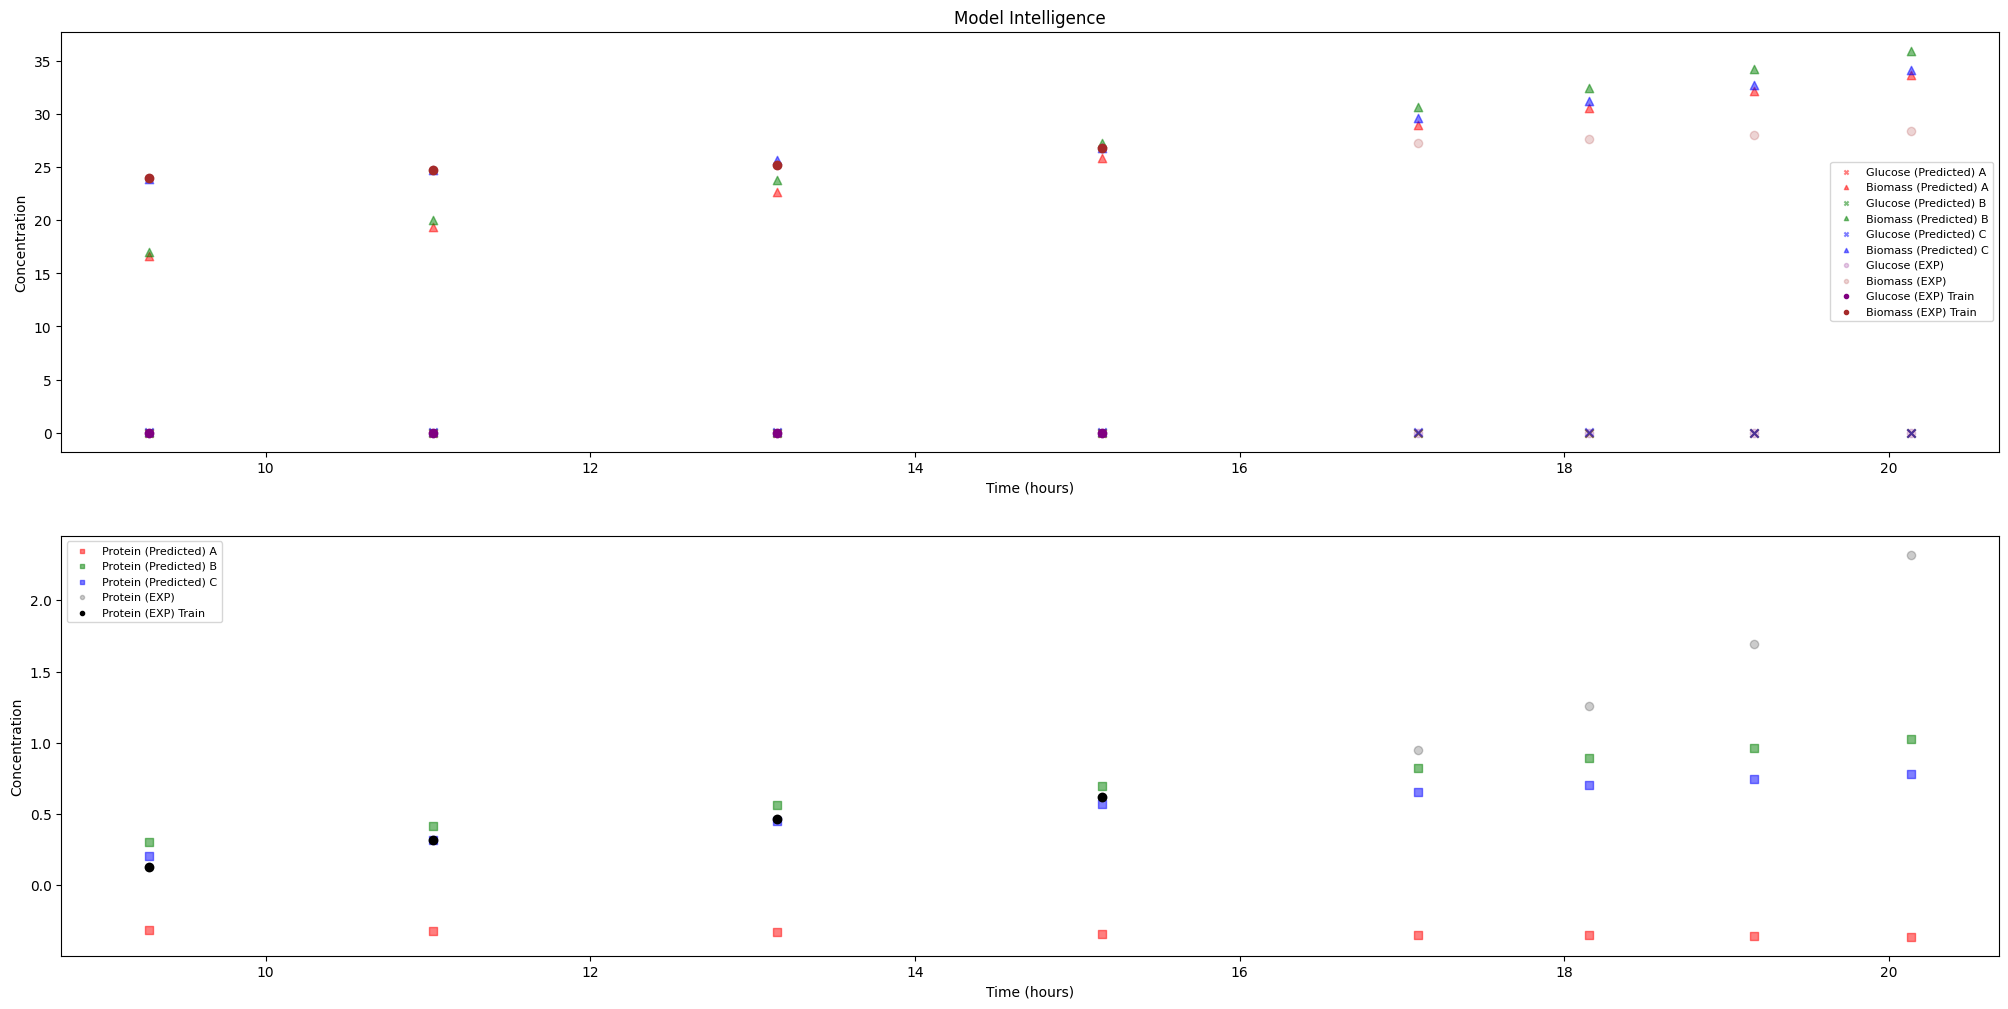

In [18]:
def plot_model_intelligence(sol_A: Union[solve_ivp, None] = None, 
                            sol_B: Union[solve_ivp, None] = None, 
                            sol_C: Union[solve_ivp, None] = None,
                            net_df_A: Union[pd.DataFrame, None] = None, 
                            net_df_B: Union[pd.DataFrame, None] = None, 
                            net_df_C: Union[pd.DataFrame, None] = None,
                            full_df: Union[pd.DataFrame, None] = None, 
                            train_df: Union[pd.DataFrame, None] = None): 
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 12))
    
    # Plot for Model A
    # ax1.plot(sol_A.t, sol_A.y[0], label='Biomass (ODE) A', color='red', alpha=0.6)
    # ax1.plot(sol_A.t, sol_A.y[1], label='Glucose (ODE) A', color='red', linestyle='--', alpha=0.6)
    # ax2.plot(sol_A.t, sol_A.y[3], label='Protein (ODE) A', color='red', alpha=0.6)
    ax1.scatter(net_df_A['RTime'], net_df_A['Glucose'], label='Glucose (Predicted) A', marker='x', color='red', alpha=0.5)
    ax1.scatter(net_df_A['RTime'], net_df_A['Biomass'], label='Biomass (Predicted) A', marker='^', color='red', alpha=0.5)
    ax2.scatter(net_df_A['RTime'], net_df_A['Protein'], label='Protein (Predicted) A', marker='s', color='red', alpha=0.5)
    
    # Plot for Model B
    # ax1.plot(sol_B.t, sol_B.y[0], label='Biomass (ODE) B', color='green', alpha=0.6)
    # ax1.plot(sol_B.t, sol_B.y[1], label='Glucose (ODE) B', color='green', linestyle='--', alpha=0.6)
    # ax2.plot(sol_B.t, sol_B.y[3], label='Protein (ODE) B', color='green', alpha=0.6)
    ax1.scatter(net_df_B['RTime'], net_df_B['Glucose'], label='Glucose (Predicted) B', marker='x', color='green', alpha=0.5)
    ax1.scatter(net_df_B['RTime'], net_df_B['Biomass'], label='Biomass (Predicted) B', marker='^', color='green', alpha=0.5)
    ax2.scatter(net_df_B['RTime'], net_df_B['Protein'], label='Protein (Predicted) B', marker='s', color='green', alpha=0.5)
    
    # Plot for Model C
    # ax1.plot(sol_C.t, sol_C.y[0], label='Biomass (ODE) C', color='blue', alpha=0.6)
    # ax1.plot(sol_C.t, sol_C.y[1], label='Glucose (ODE) C', color='blue', linestyle='--', alpha=0.6)
    # ax2.plot(sol_C.t, sol_C.y[3], label='Protein (ODE) C', color='blue', alpha=0.6)
    ax1.scatter(net_df_C['RTime'], net_df_C['Glucose'], label='Glucose (Predicted) C', marker='x', color='blue', alpha=0.5)
    ax1.scatter(net_df_C['RTime'], net_df_C['Biomass'], label='Biomass (Predicted) C', marker='^', color='blue', alpha=0.5)
    ax2.scatter(net_df_C['RTime'], net_df_C['Protein'], label='Protein (Predicted) C', marker='s', color='blue', alpha=0.5)

    # Experimental Data
    ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='purple', alpha=0.2)
    ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='brown', alpha=0.2)
    ax2.scatter(full_df['RTime'], full_df['Protein'], label='Protein (EXP)', color='black', alpha=0.2)
    
    ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (EXP) Train', color='purple', alpha=1)
    ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (EXP) Train', color='brown', alpha=1)
    ax2.scatter(train_df['RTime'], train_df['Protein'], label='Protein (EXP) Train', color='black', alpha=1)
   
    ax1.legend(fontsize=8, markerscale=0.5)
    ax2.legend(fontsize=8, markerscale=0.5)
    ax1.title.set_text('Model Intelligence') 
    ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Concentration")
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("Concentration")
    plt.show()

plot_model_intelligence(sol_A=sol_A, sol_B=sol_B, sol_C=sol_C,
                        net_df_A=net_df_A, net_df_B=net_df_B, net_df_C=net_df_C,
                        full_df=full_df, train_df=train_df)

In [19]:
net_df

NameError: name 'net_df' is not defined

In [ ]:
df.drop(columns=['Process', 'Temperature', 'Induction']).reset_index(drop=True)